![](https://images.pexels.com/photos/1077327/pexels-photo-1077327.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)

# Magnetometer Calibration

To calibrate a magnetometer, you need to get readings from all directions in 3D space. Ideally, when you plot the readings out, you should get a perfect sphere centered at (0,0,0). However, due to misalignments, offset, etc ... you end up with ellipsoids centered at some biased location.

Here we are going to try and get enough readings to estimate these errors and properly calibrate the sensor. We will load in a pre-recorded data set, where the sensor was tumbled around and calibrate it.

## References

- [Teslabs: Magnetometer Calibration](https://teslabs.com/articles/magnetometer-calibration/)
- [ThePoorEngineer: Calibrating the Magnetometer](https://www.thepoorengineer.com/en/calibrating-the-magnetometer/)

In [105]:
import numpy as np # matrix manipulations

from scipy import linalg

import the_collector # read data
print(f"the-collector: {the_collector.__version__}")

from the_collector import BagIt
from the_collector import Pickle, Json

from squaternion import Quaternion

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

# from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

from slurm import storage

from datetime import datetime
import os

the-collector: 0.8.6


In [88]:
# let's load in some data and have a look at what we have
def bag_info(bag):
    print('Bag keys:')
    print('-'*50)
    for k in bag.keys():
        print(f'  {k:>10}: {len(bag[k]):<7}')

bag = BagIt(Pickle)
fname = "~/github/data-ins-1/2020-5-3-imu/tumble.pickle.bag"
fname = os.path.expanduser(fname)

data = bag.read(fname)
bag_info(data)

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/tumble.pickle.bag
Bag keys:
--------------------------------------------------
       accel: 3193   
         mag: 3193   
        gyro: 3193   


In [89]:
# data is an array of IMU messages
def get(bag, key):
    data = {"x":[], "y":[],"z":[],"ts":[]}
    for (x,y,z),ts in bag[key]:
        data["x"].append(x)
        data["y"].append(y)
        data["z"].append(z)
        data["ts"].append(ts)
    return data

def get_np(bag, key):
    xx = []
    yy = []
    zz = []
    for (x,y,z),ts in bag[key]:
        xx.append(x)
        yy.append(y)
        zz.append(z)
    return np.array(xx), np.array(yy), np.array(zz)

mag = get_np(data, "mag")

mdf = pd.DataFrame(get(data, "mag"))
mx,my,mz,_ = mdf.mean()

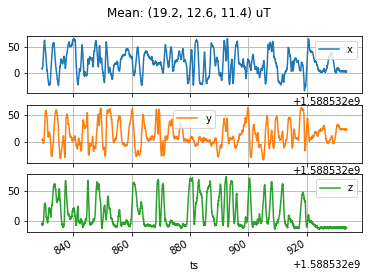

In [90]:
mdf.plot(x="ts", grid=True, subplots=True, title=f"Mean: ({mx:.1f}, {my:.1f}, {mz:.1f}) uT");

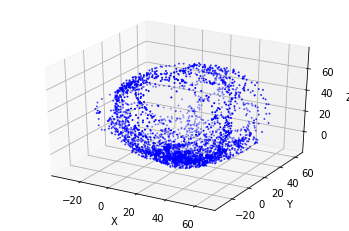

In [106]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111, projection='3d')

ax1.scatter(mag[0], mag[1], mag[2], s=1, color='b')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z');

# Save

In [32]:
import sys
import numpy as np
from scipy import linalg

class Magnetometer(object):
    '''
    F : float (optional)
        Expected earth magnetic field intensity, default=1.0.
    '''
    def __init__(self, F=1):
        self.F   = F
        self.b   = np.zeros([3, 1])
        self.A_1 = np.eye(3)
    
    def correct(self, s):
        if isinstance(s, list):
            s = np.array(s)
        return np.dot(self.A_1, s - self.b)

    def calibrate(self, s):
        ''' Performs calibration. '''
        s = s.T
        M, n, d = self.__ellipsoid_fit(s)

        # calibration parameters
        # note: some implementations of sqrtm return complex type, taking real
        M_1 = linalg.inv(M)
        self.b = -np.dot(M_1, n).T[0]  # make numpy array [bx,by,bz]
        
        self.A_1 = self.F / np.sqrt(np.abs(np.dot(n.T, np.dot(M_1, n)) - d)) 
        self.A_1 = self.A_1*np.real(linalg.sqrtm(M))
        
        return self.A_1, self.b

    def __ellipsoid_fit(self, s):
        ''' Estimate ellipsoid parameters from a set of points.

            Parameters
            ----------
            s : array_like
              The samples (M,N) where M=3 (x,y,z) and N=number of samples.

            Returns
            -------
            M, n, d : array_like, array_like, float
              The ellipsoid parameters M, n, d.
        '''

        # D (samples)
        D = np.array([s[0]**2., s[1]**2., s[2]**2.,
                      2.*s[1]*s[2], 2.*s[0]*s[2], 2.*s[0]*s[1],
                      2.*s[0], 2.*s[1], 2.*s[2], np.ones_like(s[0])])

        # S, S_11, S_12, S_21, S_22 (eq. 11)
        S = np.dot(D, D.T)
        S_11 = S[:6,:6]
        S_12 = S[:6,6:]
        S_21 = S[6:,:6]
        S_22 = S[6:,6:]

        # C (Eq. 8, k=4)
        C = np.array([[-1,  1,  1,  0,  0,  0],
                      [ 1, -1,  1,  0,  0,  0],
                      [ 1,  1, -1,  0,  0,  0],
                      [ 0,  0,  0, -4,  0,  0],
                      [ 0,  0,  0,  0, -4,  0],
                      [ 0,  0,  0,  0,  0, -4]])

        # v_1 (eq. 15, solution)
        E = np.dot(
            linalg.inv(C),
            S_11 - np.dot(S_12, np.dot(linalg.inv(S_22), S_21)))

        E_w, E_v = np.linalg.eig(E)

        v_1 = E_v[:, np.argmax(E_w)]
        if v_1[0] < 0: v_1 = -v_1

        # v_2 (eq. 13, solution)
        v_2 = np.dot(np.dot(-np.linalg.inv(S_22), S_21), v_1)

        # quadric-form parameters
        M = np.array([[v_1[0], v_1[3], v_1[4]],
                      [v_1[3], v_1[1], v_1[5]],
                      [v_1[4], v_1[5], v_1[2]]])
        n = np.array([[v_2[0]],
                      [v_2[1]],
                      [v_2[2]]])
        d = v_2[3]

        return M, n, d

In [33]:
# https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm
# uT
uT = 50.8862
m = Magnetometer(uT) 

In [34]:
def get_list(bag, key):
    d = []
    dt = []
    last = None
    for v,ts in bag[key]:
        d.append(v)
        if last is None:
            last = ts
        else:
            dt.append(ts - last)
            last=ts
    return np.array(d), np.mean(dt)

magg, dt = get_list(data, "mag")
print(f">> {dt:.3f} sec or {1/dt:.1f} Hz")

>> 0.033 sec or 30.6 Hz


In [35]:
m.calibrate(magg)

In [36]:
# """
# [[-0.3985919  -0.0180967  -0.01539174]
#  [-0.0180967  -0.42966123  0.0522018 ]
#  [-0.01539174  0.0522018  -0.80822416]]
# [[ 19.33670483]
#  [-11.646702  ]
#  [-69.15674951]]
# -7455.931326917302
# """
print(m.A_1)
print(m.b)

[[ 1.13607723  0.01426521 -0.01018889]
 [ 0.01426521  1.14363401 -0.00629215]
 [-0.01018889 -0.00629215  1.23403399]]
[20.28337018 16.52551857 29.55239641]


In [37]:
def unit(v):
    x,y,z = v
    n = 1/np.sqrt(x*x + y*y + z*z)
    return (x*n, y*n, z*n,)

orig = []
cm = []
for v in magg:
    mm = m.correct(v)
    cm.append(mm)
    
    orig.append(v)

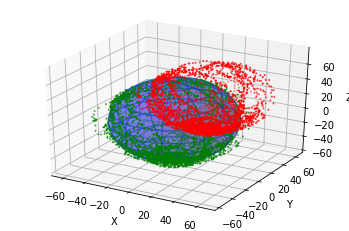

In [108]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111, projection='3d')

ax1.scatter([x[0] for x in cm],[x[1] for x in cm],[x[2] for x in cm], s=1, color='g')
ax1.scatter([x[0] for x in orig],[x[1] for x in orig],[x[2] for x in orig], s=1, color='r')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# plot unit sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = uT*np.outer(np.cos(u), np.sin(v))
y = uT*np.outer(np.sin(u), np.sin(v))
z = uT*np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_wireframe(x, y, z, rstride=10, cstride=10, alpha=0.5)
ax1.plot_surface(x, y, z, alpha=0.3, color='b');

In [39]:
error = 0
for v in cm:
    error += np.linalg.norm(v)-uT
print(error/len(cm))

-0.005550813792737799


In [43]:
A=m.A_1
b=m.b

In [44]:
ans=(np.dot(A,(magg-b).T)).T

In [45]:
error = 0
for v in ans:
    error += np.linalg.norm(v)-uT
print(error/len(ans))

-0.00555081379273808


In [83]:
def plotMagnetometer(data, title=None):
    x = [v[0] for v in data]
    y = [v[1] for v in data]
    z = [v[2] for v in data]
    plt.plot(x,y,'.b', x,z,'.r', z,y, '.g')
    plt.xlabel('$\mu$T')
    plt.ylabel('$\mu$T')
    plt.grid(True);
    plt.axis('equal')
    plt.legend(['x', 'y', 'z'])
    if title:
        plt.title(title);

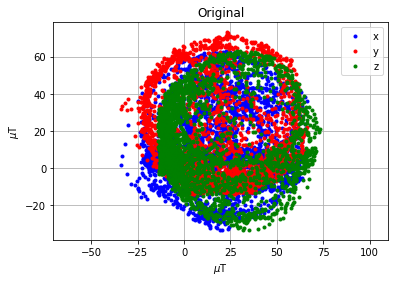

In [86]:
plotMagnetometer(orig, "Original")

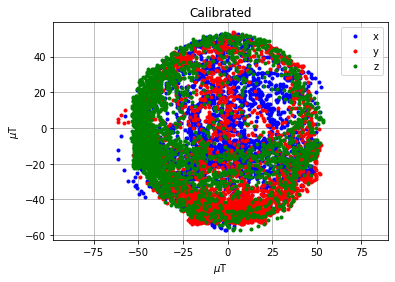

In [87]:
plotMagnetometer(cm, "Calibrated")

# Save Parameters

In [111]:
M = np.vstack((A,b))
print(M)

params = {}
params["imu"] = "adafruit NXP"
params["timestamp"] = datetime.now()
params["mag"] = M.tolist()
params["shape"] = M.shape

storage.write("magnetometer.yaml", params)

[[ 1.13607723e+00  1.42652139e-02 -1.01888869e-02]
 [ 1.42652139e-02  1.14363401e+00 -6.29215204e-03]
 [-1.01888869e-02 -6.29215204e-03  1.23403399e+00]
 [ 2.02833702e+01  1.65255186e+01  2.95523964e+01]]
